In [1]:
# Magic functions -- Run Once
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Move up one folder to reach the repo root
%cd ..

from utils.notebook.generic import full_width_notebook

full_width_notebook()

/fast-ssd/dev/maitrise/film-aqa


In [2]:
# Paths, Imports & Configs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy
from utils.notebook.experiment_explorer import get_experiments, get_format_dicts

from utils.notebook.pandas import color_by_multi_attribute
from utils.notebook.pandas import sub_cols_with_cond_and_create_new_col, grouped_scatter, groupby_mean, convert_cols_to_int

root_data_path = "data"
root_output_path = "output_synced/training"

# Retrieve all experimentsi infos
experiments = get_experiments(root_output_path, question_type_analysis=False)

# Pretty printing
format_dict, latex_format_dict = get_format_dicts()

latex_format_dict_no_agg = latex_format_dict.copy()
del latex_format_dict_no_agg['train_acc']
del latex_format_dict_no_agg['best_val_acc']
del latex_format_dict_no_agg['test_acc']

pd.set_option('display.max_colwidth', -1)

sorted(experiments.columns.values)



Failed experiment -- output_synced/training/CLEAR_50k_4_inst_audio_extractor_original_parallel_3_block_32_proj_2_epoch_876944_nnnn47/2020-09-25_18h28
Failed experiment -- output_synced/training/CLEAR_50k_4_inst_audio_config_extractor_original_interleaved_3_block_128_proj_40_epoch_666_runner_test/2020-08-18_00h31-168810
Failed experiment -- output_synced/training/CLEAR_50k_4_inst_audio_config_extractor_original_interleaved_3_block_128_proj_40_epoch_666_runner_test/2020-08-18_00h31
Failed experiment -- output_synced/training/CLEAR_50k_4_inst_audio_config_extractor_original_interleaved_3_block_128_proj_40_epoch_666_runner_test/2020-08-18_01h48
Failed experiment -- output_synced/training/CLEAR_50k_4_inst_audio_config_extractor_original_interleaved_3_block_128_proj_40_epoch_876944_runner_test/2020-08-18_00h30-96615
Failed experiment -- output_synced/training/CLEAR_50k_4_inst_audio_config_extractor_original_interleaved_3_block_128_proj_40_epoch_876944_runner_test/2020-08-18_00h30
Failed expe

/fast-ssd/dev/venv/film-aqa-torch-1.2/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


['0.6_at_epoch',
 '0.7_at_epoch',
 '0.8_at_epoch',
 '0.9_at_epoch',
 'RGB_colormap',
 'all_train_acc',
 'all_train_loss',
 'all_val_acc',
 'all_val_loss',
 'batch_size',
 'best_val_acc',
 'best_val_loss',
 'classifier_conv_out',
 'classifier_global_pool',
 'classifier_projection_out',
 'classifier_spatial_location',
 'classifier_type',
 'config',
 'date',
 'dropout_drop_prob',
 'extractor_filters',
 'extractor_nb_block',
 'extractor_out_chan',
 'extractor_projection_size',
 'extractor_spatial_location',
 'extractor_type',
 'folder',
 'folder_dated',
 'git_revision',
 'gpu_name',
 'hop_length',
 'input_type',
 'keep_freq_point',
 'max_freq',
 'mean_epoch_time',
 'n_fft',
 'n_mels',
 'nb_answer',
 'nb_epoch',
 'nb_epoch_runned',
 'nb_epoch_trained',
 'nb_non_trainable_param',
 'nb_q_per_scene',
 'nb_resblock',
 'nb_sample',
 'nb_scene',
 'nb_trainable_param',
 'nb_trainable_param_million',
 'nb_trainable_param_round',
 'norm_clear_stats',
 'norm_imagenet_stats',
 'norm_zero_one',
 'norm_

In [ ]:
# Table 1 - Extractor Types
# Static parameters :
    # G = 4096
    # J = 3
    # M = 64
    # ClassifierTopology = FCN
    # C = 512
    # H = 1024
    
# Variable parameters :
    # Extractors Type = {Parallel, Interleaved, Resnet}

filters = (experiments['date'] >= '2020-09-15')

# -- Input parameters
filters &= (experiments['resized_width'].isnull())
filters &= (~experiments['normalisation'].str.contains("imagenet_stats", na=False))

# -- Text Processing
filters &= (experiments['rnn_state_size'] == 4096)              # G

# -- Coordconv
filters &= (experiments['extractor_spatial_location'] == 'None')
filters &= (experiments['stem_spatial_location'] == 'Both')
filters &= (experiments['resblock_spatial_location'] == 'Both')
filters &= (experiments['classifier_spatial_location'] == 'Both')

# -- Resblocks
filters &= (experiments['nb_resblock'] == 4)                    # J
filters &= (experiments['resblocks_out_chan'] == 128)           # M

# -- Classifier
filters &= (experiments['classifier_conv_out'] == 512)          # C
filters &= (experiments['classifier_projection_out'] == 1024)    # H

# Variable Parameters (Input_type & Extractor)
filters &= (~experiments['RGB_colormap'].str.contains('Blues', na=False))

input_1d_filter = (experiments['input_type'].str.contains('1D'))
input_1d_filter &= (experiments['n_fft'] == 512)
input_1d_filter &= (experiments['keep_freq_point'] == 256) 
input_1d_filter &= (experiments['hop_length'] == 2048)

filters &= (experiments['input_type'].str.contains('RGB') | input_1d_filter )

#filters &= (experiments['extractor_type'].str.contains('Resnet|Parallel') | (experiments['extractor_type'].str.startswith('Interleaved')))
#filters &= (experiments['extractor_type'].str.contains('Baseline') | (experiments['extractor_type'].str.contains('Resnet')))

# -- Other
filters &= (experiments['note'].str.contains('table_1_final_final|table_2_final_final'))
#filters &= (experiments['random_seed'] == 876944)   # FIXME : Add more seeds and do the mean

# -----------------------------------------------------------------------------------------------------
exp = experiments[filters]

# Display
groupby_columns = ['extractor_type']
acc_columns = ['train_acc', 'best_val_acc', 'test_acc']
extra_columns = ['nb_trainable_param_million']#, 'folder_dated']

# Drop duplicates (Same experiment ran multiple time)
exp = exp.drop_duplicates(groupby_columns + ['random_seed'],keep='first')

# Grouping - Mean & Std calc
acc_std_columns = [f"{c}_std" for c in acc_columns]
columns = groupby_columns + acc_columns + extra_columns

exp_grouped = groupby_mean(exp, groupby_columns, acc_columns, columns, add_count_col=True, add_std_str=True)
train_std_mean, val_std_mean, test_std_mean = exp_grouped['train_acc_std'].mean() * 100, exp_grouped['best_val_acc_std'].mean() * 100, exp_grouped['test_acc_std'].mean() * 100
accuracy_std_mean = np.mean([train_std_mean, val_std_mean, test_std_mean])

exp_grouped = exp_grouped.sort_values('test_acc', ascending=False)#[columns]

# All experiments
#display(color_by_multi_attribute(exp[columns + ['random_seed', 'note']].sort_values(groupby_columns + ['random_seed'], ascending=False), main_attribute='test_acc', attributes=groupby_columns))

# Color display
display(color_by_multi_attribute(exp_grouped, main_attribute="test_acc", 
                                 attributes=[], 
                                 cmaps=['Blues'],
                                 format_dict=latex_format_dict_no_agg))

# Latex code
latex = exp_grouped[columns].to_latex(index=False, formatters=latex_format_dict).replace("\\textasciitilde", "$\\approx$")

print("\n",latex)
print(f"STD Means -- Global means : ± {accuracy_std_mean} Train : ± {train_std_mean} Val : ± {val_std_mean} - Test : ± {test_std_mean}")

In [ ]:
# Table 2 - GRU Reduction
# Static Parameters :
    # Extractor = Parallel
    # J = 4
    # M = 128
    # ClassifierTopology = FCN
    # C = 512
    # H = 1024
    # K = 3
    # N = [8, 16, 32]
    # P = 64
# Variable Parameters: 
    # G={4096,2048, 1024, 512, 256}
    
columns = ['extractor_type', 'nb_resblock', 'resblocks_out_chan', 'train_acc', 'best_val_acc', 'test_acc', 'best_val_loss', 'test_loss', 'nb_trainable_param_round', 'nb_epoch_trained']
columns = ['extractor_filters', 'classifier_conv_out', 'classifier_projection_out',  'keep_freq_point', 'hop_length', 'extractor_type', 'nb_resblock', 'resblocks_out_chan', 'train_acc', 'best_val_acc', 'test_acc', 'best_val_loss', 'test_loss', 'nb_trainable_param_round', 'nb_epoch_trained', 'folder_dated']

filters = (experiments['date'] >= '2020-11-20')

# -- Input parameters
filters &= (experiments['input_type'].str.contains('1D'))
filters &= (experiments['n_fft'] == 512)
filters &= (experiments['keep_freq_point'] == 256)
filters &= (experiments['hop_length'] == 2048)
filters &= (experiments['resized_width'].isnull())

# -- Coordconv
filters &= (experiments['extractor_spatial_location'] == 'None')
filters &= (experiments['stem_spatial_location'] == 'Both')
filters &= (experiments['resblock_spatial_location'] == 'Both')
filters &= (experiments['classifier_spatial_location'] == 'Both')

# -- Extractor
filters &= experiments['extractor_type'].str.contains('Parallel')
filters &= (experiments['extractor_nb_block'] == 3)             # K
#filters &= (experiments['extractor_filters'] == [8, 16, 32])   # N
filters &= (experiments['extractor_projection_size'] == 64)     # P      <---- FIXME : Might want to try with 32

# -- Resblocks
filters &= (experiments['nb_resblock'] == 4)                    # J
filters &= (experiments['resblocks_out_chan'] == 128)           # M

# -- Classifier
#filters &= (experiments['classifier_conv_out'] == 512)           # C 
#filters &= (experiments['classifier_projection_out'] == 1024)    # H

# Variable Parameters (Text-Processing GRU units)
filters &= (experiments['rnn_state_size'].isin([4096, 2048, 1024, 512, 256])) # G

# -- Other
filters &= (experiments['note'].str.contains('table_3|table_2_final_final'))
#filters &= (experiments['random_seed'] == 876944)   # FIXME : Add more seeds and do the mean

# -----------------------------------------------------------------------------------------------------
exp = experiments[filters]

# Display
groupby_columns = ['rnn_state_size']
acc_columns = ['train_acc', 'best_val_acc', 'test_acc']
extra_columns = ['nb_trainable_param_million']

# Drop duplicates (Same experiment ran multiple time)
exp = exp.drop_duplicates(groupby_columns + ['random_seed'],keep='first')

# Grouping - Mean & Std calc
acc_std_columns = [f"{c}_std" for c in acc_columns]
columns = groupby_columns + acc_columns + extra_columns

exp_grouped = groupby_mean(exp, groupby_columns, acc_columns, columns, add_count_col=True, add_std_str=True)
train_std_mean, val_std_mean, test_std_mean = exp_grouped['train_acc_std'].mean() * 100, exp_grouped['best_val_acc_std'].mean() * 100, exp_grouped['test_acc_std'].mean() * 100
accuracy_std_mean = np.mean([train_std_mean, val_std_mean, test_std_mean])

exp_grouped = exp_grouped.sort_values('test_acc', ascending=False)#[columns]

# All experiments
#display(color_by_multi_attribute(exp[columns + ['random_seed', 'note']].sort_values(groupby_columns + ['random_seed'], ascending=False), main_attribute='test_acc', attributes=groupby_columns))

# Color display
display(color_by_multi_attribute(exp_grouped, main_attribute='test_acc', 
                                 attributes=['rnn_state_size'],
                                 #attributes=['stem_spatial_location', 'resblock_spatial_location', 'classifier_spatial_location', 'test_acc'],
                                 cmaps=['Blues', 'YlOrRd', 'YlOrRd', 'YlOrRd', 'YlOrRd'], 
                                 format_dict=latex_format_dict))

# Latex code
latex = exp_grouped.to_latex(index=False, formatters=latex_format_dict).replace("\\textasciitilde", "$\\approx$")
print("\n",latex)

print(f"STD Means -- Global means : ± {accuracy_std_mean} Train : ± {train_std_mean} Val : ± {val_std_mean} - Test : ± {test_std_mean}")


In [ ]:
# Table 3 - Classifier Topologies
# Static Parameters :
    # Extractor = Parallel
    # J = 4
    # M = 128
    # K = 3
    # N = [8, 16, 32]
    # P = 64
# Variable Parameters :
    # Classifier Topology = {Fcn, Conv}
    # C = {512, 256, 128, None}
    # H = {1024, 512, 256, None}

filters = (experiments['date'] >= '2020-11-20')

# -- Input parameters
filters &= (experiments['input_type'].str.contains('1D'))
filters &= (experiments['n_fft'] == 512)
filters &= (experiments['keep_freq_point'] == 256)
filters &= (experiments['hop_length'] == 2048)
filters &= (experiments['resized_width'].isnull())

# -- Text Processing
filters &= (experiments['rnn_state_size'] == 1024)              # G

# -- Coordconv
filters &= (experiments['extractor_spatial_location'] == 'None')
filters &= (experiments['stem_spatial_location'] == 'Both')
filters &= (experiments['resblock_spatial_location'] == 'Both')
filters &= (experiments['classifier_spatial_location'] == 'Both')

# -- Extractor
filters &= experiments['extractor_type'].str.contains('Parallel')
filters &= (experiments['extractor_nb_block'] == 3)             # K
#filters &= (experiments['extractor_filters'] == [8, 16, 32])   # N
filters &= (experiments['extractor_projection_size'] == 64)     # P      <---- FIXME : Might want to try with 32

# -- Resblocks
filters &= (experiments['nb_resblock'] == 4)                    # J
filters &= (experiments['resblocks_out_chan'] == 128)           # M

# Variable Parameters (Classifier Topologies)
filters &= (experiments['classifier_type'].str.contains('fcn|conv'))
filters &= (experiments['classifier_conv_out'].isin([512, 256, 128, None]))          # C
filters &= (experiments['classifier_projection_out'].isin([1024, 512, 256, None]))   # H

# Other
filters &= (experiments['note'].str.contains('1_worker|table_3_table_3'))
#filters &= (experiments['random_seed'] == 876944)   # FIXME : Add more seeds and do the mean

# -----------------------------------------------------------------------------------------------------
exp = experiments[filters]

# Display
groupby_columns = ['classifier_type', 'classifier_conv_out', 'classifier_projection_out']
acc_columns = ['train_acc', 'best_val_acc', 'test_acc']
extra_columns = ['nb_trainable_param_million']

# Drop duplicates (Same experiment ran multiple time)
exp = exp.drop_duplicates(groupby_columns + ['random_seed'],keep='first')

# Grouping - Mean & Std calc
acc_std_columns = [f"{c}_std" for c in acc_columns]
columns = groupby_columns + acc_columns + extra_columns

exp_grouped = groupby_mean(exp, groupby_columns, acc_columns, columns, add_count_col=True, add_std_str=True)
train_std_mean, val_std_mean, test_std_mean = exp_grouped['train_acc_std'].mean() * 100, exp_grouped['best_val_acc_std'].mean() * 100, exp_grouped['test_acc_std'].mean() * 100
accuracy_std_mean = np.mean([train_std_mean, val_std_mean, test_std_mean])

exp_grouped = exp_grouped.sort_values('test_acc', ascending=False)#[columns]

# All experiments
#display(color_by_multi_attribute(exp[columns + ['random_seed', 'note']].sort_values(groupby_columns + ['random_seed'], ascending=False), main_attribute='test_acc', attributes=groupby_columns))

# Color display
display(color_by_multi_attribute(exp_grouped, main_attribute='test_acc', 
                                 attributes=['classifier_type'],# 'classifier_conv_out', 'classifier_projection_out'],
                                 cmaps=['Blues'], 
                                 format_dict=latex_format_dict))

# Latex code
latex = exp_grouped.to_latex(index=False, formatters=latex_format_dict).replace("\\textasciitilde", "$\\approx$")

print("\n",latex)
print(f"STD Means -- Global means : ± {accuracy_std_mean} Train : ± {train_std_mean} Val : ± {val_std_mean} - Test : ± {test_std_mean}")

In [ ]:
# Table 4 - Resblocks
# Static parameters
    # Extractor = Parallel
    # K = 3
    # N = [8, 16, 32]
    # P = 64
    # ClassifierTopology = FCN
    # C = 512
    # H = 1024
# Variable Parameters
    # J = {4, 3, 2, 1}
    # M = {128, 64, 32}

filters = (experiments['date'] >= '2020-11-20')

# -- Input parameters
filters &= (experiments['input_type'].str.contains('1D'))
filters &= (experiments['n_fft'] == 512)
filters &= (experiments['keep_freq_point'] == 256)
filters &= (experiments['hop_length'] == 2048)
filters &= (experiments['resized_width'].isnull())

# -- Text Processing
filters &= (experiments['rnn_state_size'] == 1024)              # G

# -- Coordconv
filters &= (experiments['extractor_spatial_location'] == 'None')
filters &= (experiments['stem_spatial_location'] == 'Both')
filters &= (experiments['resblock_spatial_location'] == 'Both')
filters &= (experiments['classifier_spatial_location'] == 'Both')

# -- Extractor
filters &= experiments['extractor_type'].str.contains('Parallel')
filters &= (experiments['extractor_nb_block'] == 3)             # K
#filters &= (experiments['extractor_filters'] == [8, 16, 32])   # N
filters &= (experiments['extractor_projection_size'] == 64)     # P      <---- FIXME : Might want to try with 32

# -- Classifier
filters &= (experiments['classifier_conv_out'] == 128)          # C      <---- FIXME: Make sure this is the good values
filters &= (experiments['classifier_projection_out'] == 512)    # H      <---- FIXME: Make sure this is the good values

# Variable Parameters (Resblocks)
filters &= (experiments['nb_resblock'] <= 4)                    # J
filters &= (experiments['resblocks_out_chan'].isin([128, 64, 32]))           # M

# -- Other
filters &= (experiments['note'].str.contains('table_5_final|table_4.*1_worker'))    # Table 4 result for comparison
#filters &= (experiments['random_seed'] == 876944)   # FIXME : Add more seeds and do the mean

# -- Comparison
#filters |= ( (experiments['nb_resblock'] == 4) & (experiments['resblocks_out_chan'] == 128) & (experiments['note'].str.contains('table_4.*1_worker')) & experiments['extractor_type'].str.contains('Parallel') & (experiments['classifier_conv_out'] == 128) & (experiments['classifier_projection_out'] == 512) )

# -----------------------------------------------------------------------------------------------------
exp = experiments[filters]

# Display
groupby_columns = ['nb_resblock', 'resblocks_out_chan']
acc_columns = ['train_acc', 'best_val_acc', 'test_acc']
extra_columns = ['nb_trainable_param_million']

# Drop duplicates (Same experiment ran multiple time)
exp = exp.drop_duplicates(groupby_columns + ['random_seed'],keep='first')

# Grouping - Mean & Std calc
acc_std_columns = [f"{c}_std" for c in acc_columns]
columns = groupby_columns + acc_columns + extra_columns

exp_grouped = groupby_mean(exp, groupby_columns, acc_columns, columns, add_count_col=True, add_std_str=True)
train_std_mean, val_std_mean, test_std_mean = exp_grouped['train_acc_std'].mean() * 100, exp_grouped['best_val_acc_std'].mean() * 100, exp_grouped['test_acc_std'].mean() * 100
accuracy_std_mean = np.mean([train_std_mean, val_std_mean, test_std_mean])

exp_grouped = exp_grouped.sort_values('test_acc', ascending=False)#[columns]

# All experiments
#display(color_by_multi_attribute(exp[columns + ['random_seed', 'note']].sort_values(groupby_columns + ['random_seed'], ascending=False), main_attribute='test_acc', attributes=groupby_columns))

# Color display
display(color_by_multi_attribute(exp_grouped, main_attribute='test_acc', 
                                 attributes=[],
                                 #attributes=['stem_spatial_location', 'resblock_spatial_location', 'classifier_spatial_location', 'test_acc'],
                                 cmaps=['Blues', 'YlOrRd', 'YlOrRd', 'YlOrRd', 'YlOrRd'], 
                                 format_dict=latex_format_dict))

# Latex code
latex = exp_grouped.to_latex(index=False, formatters=latex_format_dict).replace("\\textasciitilde", "$\\approx$")

print("\n",latex)
print(f"STD Means -- Global means : ± {accuracy_std_mean} Train : ± {train_std_mean} Val : ± {val_std_mean} - Test : ± {test_std_mean}")


In [ ]:
# Table 5 - Extractor filter reduction
# Static parameters :
    # G = 1024
    # J = 3
    # M = 64
    # ClassifierTopology = FCN
    # C = 512
    # H = 1024
# Variable parameters :
    # k = {4,3,2,1}
    # P = {128, 64, 32, None}

filters = (experiments['date'] >= '2020-11-20')

# -- Input parameters
filters &= (experiments['input_type'].str.contains('1D'))
filters &= (experiments['n_fft'] == 512)
filters &= (experiments['keep_freq_point'] == 256)
filters &= (experiments['hop_length'] == 2048)
filters &= (experiments['resized_width'].isnull())

# -- Text Processing
filters &= (experiments['rnn_state_size'] == 1024)              # G

# -- Coordconv
filters &= (experiments['extractor_spatial_location'] == 'None')
filters &= (experiments['stem_spatial_location'] == 'Both')
filters &= (experiments['resblock_spatial_location'] == 'Both')
filters &= (experiments['classifier_spatial_location'] == 'Both')

# -- Resblocks
filters &= (experiments['nb_resblock'] == 3)                   # J       <---- FIXME: Make sure this is the good values
filters &= (experiments['resblocks_out_chan'] == 64)           # M       <---- FIXME: Make sure this is the good values

# -- Classifier
filters &= (experiments['classifier_conv_out'] == 128)          # C      <---- FIXME: Make sure this is the good values
filters &= (experiments['classifier_projection_out'] == 512)    # H      <---- FIXME: Make sure this is the good values

# Variable Parameters (Extractor configuration)
#filters &= experiments['extractor_type'].str.contains('Parallel|Interleaved')
filters &= experiments['extractor_type'].str.contains('Parallel')
filters &= (experiments['extractor_nb_block'] <= 4)             # K
#filters &= (experiments['extractor_filters'] == [8, 16, 32])   # N
filters &= (experiments['extractor_projection_size'].isin([128, 64, 32, None]))     # P

# -- Other
#filters &= (experiments['random_seed'] == 876944)   # FIXME : Add more seeds and do the mean

# -----------------------------------------------------------------------------------------------------
exp = experiments[filters]

# Display
groupby_columns = ['extractor_nb_block', 'extractor_projection_size']
acc_columns = ['train_acc', 'best_val_acc', 'test_acc']
extra_columns = ['nb_trainable_param_million']

# Drop duplicates (Same experiment ran multiple time)
exp = exp.drop_duplicates(groupby_columns + ['random_seed'],keep='first')

# Grouping - Mean & Std calc
acc_std_columns = [f"{c}_std" for c in acc_columns]
columns = groupby_columns + acc_columns + extra_columns

exp_grouped = groupby_mean(exp, groupby_columns, acc_columns, columns, add_count_col=True, add_std_str=True)
train_std_mean, val_std_mean, test_std_mean = exp_grouped['train_acc_std'].mean() * 100, exp_grouped['best_val_acc_std'].mean() * 100, exp_grouped['test_acc_std'].mean() * 100
accuracy_std_mean = np.mean([train_std_mean, val_std_mean, test_std_mean])

exp_grouped = exp_grouped.sort_values('test_acc', ascending=False)#[columns]

# All experiments
#display(color_by_multi_attribute(exp[columns + ['random_seed', 'note']].sort_values(groupby_columns + ['random_seed'], ascending=False), main_attribute='test_acc', attributes=groupby_columns))

# Color display
display(color_by_multi_attribute(exp_grouped, main_attribute='test_acc', 
                                 attributes=['extractor_nb_block', 'extractor_projection_size'],
                                 #attributes=['stem_spatial_location', 'resblock_spatial_location', 'classifier_spatial_location', 'test_acc'],
                                 cmaps=['Blues'], 
                                 format_dict=latex_format_dict))

# Latex code
latex = exp_grouped.to_latex(index=False, formatters=latex_format_dict).replace("\\textasciitilde", "$\\approx$")

print("\n",latex)
print(f"STD Means -- Global means : ± {accuracy_std_mean} Train : ± {train_std_mean} Val : ± {val_std_mean} - Test : ± {test_std_mean}")

In [ ]:
# Table 7 - CoordConv
    # K = 3
    # N_0 = 8
    # P = 64
    # G = 1024
    # J = 3
    # M = 64
    # ClassifierTopology = FCN
    # C = 512
    # H = 1024
columns = ['extractor_spatial_location', 'stem_spatial_location', 'resblock_spatial_location', 'classifier_spatial_location' , 'train_acc', 'best_val_acc', 'test_acc', 'best_val_loss', 'test_loss', 'nb_trainable_param_round', 'nb_epoch_trained']
#columns = ['extractor_filters', 'classifier_conv_out', 'classifier_projection_out',  'keep_freq_point', 'hop_length', 'extractor_type', 'nb_resblock', 'resblocks_out_chan', 'train_acc', 'best_val_acc', 'test_acc', 'best_val_loss', 'test_loss', 'nb_trainable_param_round', 'nb_epoch_trained', 'folder_dated']


filters = (experiments['date'] >= '2020-11-20')
#filters = (experiments['date'] >= '2020-09-20')

# -- Input parameters
filters &= (experiments['input_type'].str.contains('1D'))
filters &= (experiments['n_fft'] == 512)
filters &= (experiments['keep_freq_point'] == 256)
filters &= (experiments['hop_length'] == 2048)
filters &= (experiments['resized_width'].isnull())

# -- Text Processing
filters &= (experiments['rnn_state_size'] == 1024)              # G

# -- Extractor
filters &= (experiments['extractor_nb_block'] == 3)             # K
#filters &= (experiments['extractor_filters'] == [8, 16, 32])   # N
filters &= (experiments['extractor_projection_size'] == 64)     # P

# -- Resblocks
filters &= (experiments['nb_resblock'] == 3)                   # J       <---- FIXME: Make sure this is the good values
filters &= (experiments['resblocks_out_chan'] == 64)           # M       <---- FIXME: Make sure this is the good values

# -- Classifier
filters &= (experiments['classifier_conv_out'] == 128)          # C      <---- FIXME: Make sure this is the good values
filters &= (experiments['classifier_projection_out'] == 512)    # H      <---- FIXME: Make sure this is the good values

# Variable Parameters (CoordConv)
filters &= (experiments['extractor_spatial_location'].str.contains('None|Time|Freq|Both'))
filters &= (experiments['stem_spatial_location'].str.contains('None|Time|Freq|Both'))
filters &= (experiments['resblock_spatial_location'].str.contains('None|Time|Freq|Both'))
filters &= (experiments['classifier_spatial_location'].str.contains('None|Time|Freq|Both'))

# -- Other
filters &= (experiments['note'].str.contains('table_7|table_5_final'))
#filters &= (experiments['random_seed'] == 876944)   # FIXME : Add more seeds and do the mean

# -----------------------------------------------------------------------------------------------------
exp = experiments[filters]

# Display
groupby_columns = ['extractor_spatial_location', 'stem_spatial_location', 'resblock_spatial_location', 'classifier_spatial_location']
acc_columns = ['train_acc', 'best_val_acc', 'test_acc']
extra_columns = ['nb_trainable_param_million']#, 'folder_dated']

# Drop duplicates (Same experiment ran multiple time)
exp = exp.drop_duplicates(groupby_columns + ['random_seed'],keep='first')

# Grouping - Mean & Std calc
acc_std_columns = [f"{c}_std" for c in acc_columns]
columns = groupby_columns + acc_columns + extra_columns

exp_grouped = groupby_mean(exp, groupby_columns, acc_columns, columns, add_count_col=True, add_std_str=True)
train_std_mean, val_std_mean, test_std_mean = exp_grouped['train_acc_std'].mean() * 100, exp_grouped['best_val_acc_std'].mean() * 100, exp_grouped['test_acc_std'].mean() * 100
accuracy_std_mean = np.mean([train_std_mean, val_std_mean, test_std_mean])

exp_grouped = exp_grouped.sort_values('test_acc', ascending=False)#[columns]

#display(color_by_multi_attribute(exp[columns + ['random_seed', 'note']].sort_values(groupby_columns + ['random_seed'], ascending=False), main_attribute='test_acc', attributes=groupby_columns))

# Color display
display(color_by_multi_attribute(exp_grouped, main_attribute='test_acc', 
                                 attributes=['extractor_spatial_location', 'stem_spatial_location', 'resblock_spatial_location', 'classifier_spatial_location', 'test_acc', 'test_acc_std'],
                                 cmaps=['Blues', 'YlOrRd', 'YlOrRd', 'YlOrRd', 'YlOrRd'], 
                                 format_dict=latex_format_dict))

# Latex code
latex = exp_grouped.to_latex(index=False, formatters=latex_format_dict).replace("\\textasciitilde", "$\\approx$")

print("\n",latex)
print(f"STD Means -- Global means : ± {accuracy_std_mean} Train : ± {train_std_mean} Val : ± {val_std_mean} - Test : ± {test_std_mean}")


In [ ]:
from utils.notebook.experiment_explorer import get_full_sync_experiment_from_drive_script

get_full_sync_experiment_from_drive_script(exp, root_output_path, dryrun=True)[0]

In [ ]:
# Baseline model
    # RGB vs 1D
    # Resnet    
    # Mel Vs Spectrograms

# Our model
    # Baseline (4Resblock_128filters) + Parallel extractor
    # Baseline (4Resblock_128filters) + Interleaved Extractor
    # Our best configuration for parallel extractor
    # Our best configuration for Interleaved extractor
    
# Parameter reduction
    # Best extractor (Either parallel or interleaved)
        # GRU
        # Classifier
        # Resblocks

# Dataset Sizes

# One modality

# Batching

In [ ]:
# Our model
    # Baseline (4Resblock_128filters) + Parallel extractor
    # Baseline (4Resblock_128filters) + Interleaved Extractor
    # Our best configuration for parallel extractor
    # Our best configuration for Interleaved extractor
    
columns = ['extractor_filters', 'extractor_projection_size', 'test_acc', 'max_freq', 'n_fft', 'keep_freq_point', 'extractor_type', 'nb_trainable_param_round', 'note', 'folder']

# From recent experiments
filters = (experiments['date'] >= '2020-09-01')

# Parallel or Interleaved extractor
filters &= (experiments['extractor_type'].isin(['freq_time_interlaced', 'freq_time_separated']))

# Baseline Resblocks config
filters &= (experiments['nb_resblock'] == 4) & (experiments['resblocks_out_chan'] == 128)

filters &= (experiments['n_mels'].isnull())


exp = experiments[filters].sort_values('test_acc', ascending=False)

# NOTE : Hardcoded... This is dependant on the order of the DF..
names_by_index = {
    500: '1D-ConvLearned',
    391: 'RGB-Resnet-Imagenet-Stats',
    248: 'RGB-ConvLearned',
    130: 'RGB-Resnet-ClearStats',
    392: 'RGB-Resnet-Imagenet-Renorm'
}

#for index, name in names_by_index.items():
#    exp.loc[index, 'name'] = name

exp['name'] = exp.apply(lambda x: '4ResBl-128F', axis=1)
columns = ['name'] + columns

color_by_multi_attribute(exp[columns], main_attribute="extractor_type", attributes=['n_fft'], format_dict=latex_format_dict)

#exp[columns].style.format(latex_format_dict)

In [ ]:
# Parameter reduction
    # Best extractor (Either parallel or interleaved)
        # GRU
    
columns = ['rnn_state_size', 'extractor_filters', 'extractor_projection_size', 'test_acc', 'max_freq', 'n_fft', 'keep_freq_point', 'extractor_type', 'nb_trainable_param_round']#, 'note', 'folder']

# From recent experiments
filters = (experiments['date'] >= '2020-09-01')

# Parallel or Interleaved extractor
filters &= (experiments['extractor_type'].isin(['freq_time_interlaced', 'freq_time_separated']))

# Baseline Resblocks config
filters &= (experiments['nb_resblock'] == 3) & (experiments['resblocks_out_chan'] == 64)

filters &= (experiments['n_mels'].isnull())


exp = experiments[filters].sort_values('test_acc', ascending=False)

# NOTE : Hardcoded... This is dependant on the order of the DF..
names_by_index = {
    500: '1D-ConvLearned',
    391: 'RGB-Resnet-Imagenet-Stats',
    248: 'RGB-ConvLearned',
    130: 'RGB-Resnet-ClearStats',
    392: 'RGB-Resnet-Imagenet-Renorm'
}

#for index, name in names_by_index.items():
#    exp.loc[index, 'name'] = name

exp['name'] = exp.apply(lambda x: '3ResBl-64F', axis=1)
columns = ['name'] + columns

color_by_multi_attribute(exp[columns], main_attribute="extractor_type", attributes=['n_fft'], format_dict=latex_format_dict)

#exp[columns].style.format(latex_format_dict)

In [ ]:
# Parameter reduction
    # Best extractor (Either parallel or interleaved)
        # Classifier
    
columns = ['classifier_type', 'classifier_conv_out', 'classifier_projection_out', 'classifier_global_pool', 'extractor_filters', 'extractor_projection_size', 'test_acc', 'max_freq', 'n_fft', 'keep_freq_point', 'extractor_type', 'nb_trainable_param_round', 'note', 'folder']

# From recent experiments
filters = (experiments['date'] >= '2020-09-01')

# Parallel or Interleaved extractor
filters &= (experiments['extractor_type'].isin(['freq_time_interlaced', 'freq_time_separated']))

# Baseline Resblocks config
filters &= (experiments['nb_resblock'] == 3) & (experiments['resblocks_out_chan'] == 64)

filters &= (experiments['n_mels'].isnull())


exp = experiments[filters].sort_values('test_acc', ascending=False)

# NOTE : Hardcoded... This is dependant on the order of the DF..
names_by_index = {
    500: '1D-ConvLearned',
    391: 'RGB-Resnet-Imagenet-Stats',
    248: 'RGB-ConvLearned',
    130: 'RGB-Resnet-ClearStats',
    392: 'RGB-Resnet-Imagenet-Renorm'
}

#for index, name in names_by_index.items():
#    exp.loc[index, 'name'] = name

exp['name'] = exp.apply(lambda x: '3ResBl-64F', axis=1)
columns = ['name'] + columns

color_by_multi_attribute(exp[columns], main_attribute="extractor_type", attributes=['n_fft'], format_dict=latex_format_dict)

#exp[columns].style.format(latex_format_dict)

In [ ]:
# Parameter reduction
    # Best extractor (Either parallel or interleaved)
        # Resblocks
    
columns = ['nb_resblock', 'resblocks_out_chan', 'extractor_filters', 'extractor_projection_size', 'test_acc', 'max_freq', 'n_fft', 'keep_freq_point', 'extractor_type', 'nb_trainable_param_round', 'note', 'folder']

# From recent experiments
filters = (experiments['date'] >= '2020-09-01')

# Parallel or Interleaved extractor
filters &= (experiments['extractor_type'].isin(['freq_time_interlaced', 'freq_time_separated']))

filters &= (experiments['n_mels'].isnull())


exp = experiments[filters].sort_values('test_acc', ascending=False)

# NOTE : Hardcoded... This is dependant on the order of the DF..
names_by_index = {
    500: '1D-ConvLearned',
    391: 'RGB-Resnet-Imagenet-Stats',
    248: 'RGB-ConvLearned',
    130: 'RGB-Resnet-ClearStats',
    392: 'RGB-Resnet-Imagenet-Renorm'
}

#for index, name in names_by_index.items():
#    exp.loc[index, 'name'] = name

exp['name'] = exp.apply(lambda x: '3ResBl-64F', axis=1)
columns = ['name'] + columns

color_by_multi_attribute(exp[columns], main_attribute="extractor_type", attributes=['n_fft'], format_dict=latex_format_dict)

#exp[columns].style.format(latex_format_dict)

In [ ]:
exp

# Table Generation

In [ ]:
## Network reduction -- GRU units
df_filter = ((experiments['note'] == 'final_dropout') & (experiments['config'].str.contains('reduction')) & (~experiments['config'].str.contains('proj')) & (~experiments['config'].str.contains('conv')) & (experiments['classifier_type'] == 'fcn'))
columns = ['nb_trainable_param', 'rnn_state_size', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']
GRU_table = experiments[df_filter][columns].sort_values('nb_trainable_param', ascending=False).reset_index(drop=True)

text = ['hola', 'quetal', 'muybien', 'tu', 'fff']
GRU_table['text'] = GRU_table.apply(lambda s: text[s.name], axis=1)

# Reorder columns (Set text first)
GRU_table = GRU_table[['text'] + GRU_table.columns.tolist()[:-1]]

#print(GRU_table.to_latex(index=False, formatters=latex_format_dict))
GRU_table.style.format(latex_format_dict)

In [ ]:
## Network reduction -- Classifier
df_filter =  (experiments['note'] == 'final') & (experiments['config'].str.contains('reduction'))
df_filter &= (~experiments['config'].str.contains('extractor')) & (~experiments['config'].str.contains('proj'))
df_filter &= (experiments['rnn_state_size'].isin([4096, 1024, 256]))

columns = ['nb_trainable_param', 'rnn_state_size', 'classifier_type', 'classifier_conv_out', 'classifier_projection_out', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_trained']#, 'train_time']
classifier = experiments[df_filter].sort_values('nb_trainable_param', ascending=False)[columns]

#print(classifier.to_latex(index=False, formatters=latex_format_dict))
classifier.style.format(latex_format_dict)

In [ ]:
## Network reduction -- Reduction Filters/Nb Resblocks
df_filter =  (experiments['note'] == 'final') & (experiments['config'].str.contains('reduction'))
df_filter &= (experiments['config'].str.contains('extractor')) & (~experiments['config'].str.contains('proj'))
df_filter &= (experiments['rnn_state_size'].isin([4096, 1024, 256]))

only_rnn_reduction_filter = (experiments['note'] == 'final') & (experiments['config'].isin(['reduction_original_rnn_1024_fcn_no_conv_hidden_256', "reduction_original_rnn_1024_fcn_conv_256_hidden_512"]))

df_filter |= only_rnn_reduction_filter

columns = ['nb_trainable_param', 'extractor_out_chan', 'stem_out_chan', 'nb_resblock', 'classifier_conv_out', 'classifier_projection_out', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']

reduction_experiments = experiments[df_filter].sort_values('nb_trainable_param', ascending=False)[columns]

#print(reduction_experiments.to_latex(index=False, formatters=latex_format_dict))
reduction_experiments.style.format(latex_format_dict)

In [ ]:
## Feature Extractor -- Parallel Extractor
df_filter = (experiments['note'] == 'extractor') & (experiments['extractor_type'] == 'freq_time_separated')

columns = ['extractor_filters', 'extractor_projection_size', 'extractor_out_chan', 'train_acc', 'best_val_acc', 'test_acc', 'nb_trainable_param']#, 'train_time']

parallel_extractor = experiments[df_filter]

# Average Results grouped over ['config', 'nb_scene', 'nb_q_per_scene']
parallel_extractor = groupby_mean(parallel_extractor, 
                                     groupby_columns=['config', 'nb_scene', 'nb_q_per_scene'],
                                     mean_columns=['train_acc', 'best_val_acc', 'test_acc'],
                                    selected_columns=columns,
                                    add_count_col=False)

#parallel_extractor = convert_cols_to_int(parallel_extractor, ['nb_epoch_runned'])

parallel_extractor = parallel_extractor.sort_values('nb_trainable_param', ascending=False)#[columns]

#print(parallel_extractor.to_latex(index=False, formatters=latex_format_dict))
parallel_extractor.style.format(latex_format_dict)

In [ ]:
## Feature Extractor -- Interlaced Extractor -- Time First
df_filter = (experiments['note'] == 'extractor') & (experiments['extractor_type'] == 'freq_time_interlaced')
df_filter &= (experiments['config'].str.contains('timefirst'))

columns = ['nb_trainable_param', 'extractor_nb_block', 'extractor_filters', 'extractor_projection_size', 'extractor_out_chan', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']

interleaved_extractor_timefirst = experiments[df_filter]

# Average Results grouped over ['config', 'nb_scene', 'nb_q_per_scene']
interleaved_extractor_timefirst = groupby_mean(interleaved_extractor_timefirst, 
                                     groupby_columns=['config', 'nb_scene', 'nb_q_per_scene'],
                                     mean_columns=['train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned'],
                                    selected_columns=columns,
                                    add_count_col=False)

interleaved_extractor_timefirst = convert_cols_to_int(interleaved_extractor_timefirst, ['nb_epoch_runned'])
interleaved_extractor_timefirst = interleaved_extractor_timefirst.sort_values('test_acc', ascending=False)#[columns]

#print(interleaved_extractor_timefirst.to_latex(index=False, formatters=latex_format_dict))
interleaved_extractor_timefirst.style.format(latex_format_dict)

In [ ]:
## Feature Extractor -- Interlaced Extractor -- Freq First
df_filter = (experiments['note'] == 'extractor') & (experiments['extractor_type'] == 'freq_time_interlaced')
df_filter &= (~experiments['config'].str.contains('timefirst'))

columns = ['nb_trainable_param', 'extractor_nb_block', 'extractor_filters', 'extractor_projection_size', 'extractor_out_chan', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']

interleaved_extractor_freqfirst = experiments[df_filter]

# Average Results grouped over ['config', 'nb_scene', 'nb_q_per_scene']
interleaved_extractor_freqfirst = groupby_mean(interleaved_extractor_freqfirst, 
                                     groupby_columns=['config', 'nb_scene', 'nb_q_per_scene'],
                                     mean_columns=['train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned'],
                                    selected_columns=columns,
                                    add_count_col=False)

interleaved_extractor_freqfirst = convert_cols_to_int(interleaved_extractor_freqfirst, ['nb_epoch_runned'])
interleaved_extractor_freqfirst = interleaved_extractor_freqfirst.sort_values('nb_trainable_param', ascending=False)#[columns]

#print(interleaved_extractor_freqfirst.to_latex(index=False, formatters=latex_format_dict))
interleaved_extractor_freqfirst.style.format(latex_format_dict)

<IPython.core.display.Javascript object>


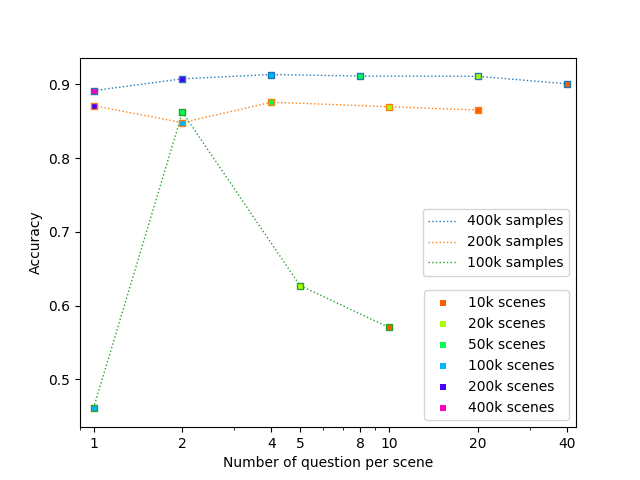

/fast-ssd/dev/venv/film-aqa-torch-1.2/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/fast-ssd/dev/venv/film-aqa-torch-1.2/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/fast-ssd/dev/venv/film-aqa-torch-1.2/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/fast-ssd/dev/venv/film-aqa-torch-1.2/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: F

Text(0, 0.5, 'Accuracy')

In [3]:
## Dataset size comparison -- Mixed -- 100k, 200k, 400k samples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np


fig_name = "dataset_size_all_samples.pdf"
df_filter = (experiments['note'] == 'dataset_size')
columns = ['nb_sample', 'nb_scene', 'nb_q_per_scene', 'test_acc']
dataset_size = experiments[df_filter].sort_values('nb_q_per_scene')


fig, ax = plt.subplots()
lines = []

grouped_by_sample_400k = dataset_size[dataset_size['nb_sample'] == 400000]

# Get colorlist
group_unique_keys = grouped_by_sample_400k['nb_scene'].unique()
colorlist = {key: colors.rgb2hex(matplotlib.cm.gist_rainbow_r(i)) for key, i in
             zip(group_unique_keys, np.linspace(0, 0.9, len(group_unique_keys)))}

# Plot 400k lines & markers
lines += ax.plot(grouped_by_sample_400k['nb_q_per_scene'], grouped_by_sample_400k['test_acc'], linewidth=1, linestyle=':', zorder=1)
grouped_scatter(grouped_by_sample_400k, 'nb_scene', 'nb_q_per_scene', 'test_acc', ax = ax, show_label=True, colorlist=colorlist, 
                label_modifier=lambda n: f"{int(n/1000)}k scenes  ", additional_params={"marker": ",", "zorder":2, "edgecolor":lines[0].get_markerfacecolor(), "linewidth":1})

# Plot 200k lines & markers
grouped_by_sample_200k = dataset_size[dataset_size['nb_sample'] == 200000]
lines += ax.plot(grouped_by_sample_200k['nb_q_per_scene'], grouped_by_sample_200k['test_acc'], linewidth=1, linestyle=':', zorder=1)
grouped_scatter(grouped_by_sample_200k, 'nb_scene', 'nb_q_per_scene', 'test_acc', ax = ax, show_label=False, colorlist=colorlist, additional_params={"marker": ",", "zorder":2, "edgecolor":lines[1].get_markerfacecolor(), "linewidth":1})

# Plot 100k lines & markers
grouped_by_sample_100k = dataset_size[dataset_size['nb_sample'] == 100000]
lines += ax.plot(grouped_by_sample_100k['nb_q_per_scene'], grouped_by_sample_100k['test_acc'], linewidth=1, linestyle=':', zorder=1)
grouped_scatter(grouped_by_sample_100k, 'nb_scene', 'nb_q_per_scene', 'test_acc', ax = ax, show_label=False, colorlist=colorlist, additional_params={"marker": ",", "zorder":2, "edgecolor":lines[2].get_markerfacecolor(), "linewidth":1})

# Remove marker border from legend
for legend_handle in ax.get_legend().legendHandles:
    legend_handle.set_linewidths(0)

# Add Second legend
ax.add_artist(matplotlib.legend.Legend(ax, lines, ['400k samples', '200k samples', '100k samples'], loc='center right'))

# Set axis infos
ax.set_xscale('log')
ax.set_xticks(dataset_size['nb_q_per_scene'].unique())
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlim([0.9, 43])
ax.set_xlabel('Number of question per scene')
ax.set_ylabel('Accuracy')

#fig.savefig(f"stats/{fig_name}", bbox_inches='tight')

In [5]:
## Dataset size comparison -- Mixed -- 100k, 200k, 400k samples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

fig_name = "dataset_size_all_samples_giampi.pdf"
df_filter = (experiments['note'] == 'dataset_size')
columns = ['nb_sample', 'nb_scene', 'nb_q_per_scene', 'test_acc']
dataset_size = experiments[df_filter].sort_values('nb_q_per_scene')
#print(dataset_size)

fig, ax = plt.subplots()
sns.set_palette("colorblind")
g = sns.barplot(x='nb_scene', y='test_acc', hue='nb_sample', data=dataset_size)
# the following is an ugly hack that only works if the accuracy values are all different!!
for patch in ax.patches:
    if np.isnan(patch.get_height()):
        continue
    idx = np.argmin(np.abs(dataset_size.test_acc-patch.get_height()))
    #g.text(patch.get_x()+patch.get_width()/2, patch.get_height(), dataset_size.nb_q_per_scene[idx], color='black', ha='center')
    g.text(patch.get_x()+patch.get_width()/2, 0.96, dataset_size.nb_q_per_scene[idx], color='black', ha='center')
g.text(1.5, 1.01, '# questions per scene', color='black')
plt.xlabel('# scenes')
plt.ylabel('Accuracy')
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, title='# examples', loc='lower left')

#fig.savefig(f"stats/{fig_name}", bbox_inches='tight')

<IPython.core.display.Javascript object>

KeyError: 11

<IPython.core.display.Javascript object>


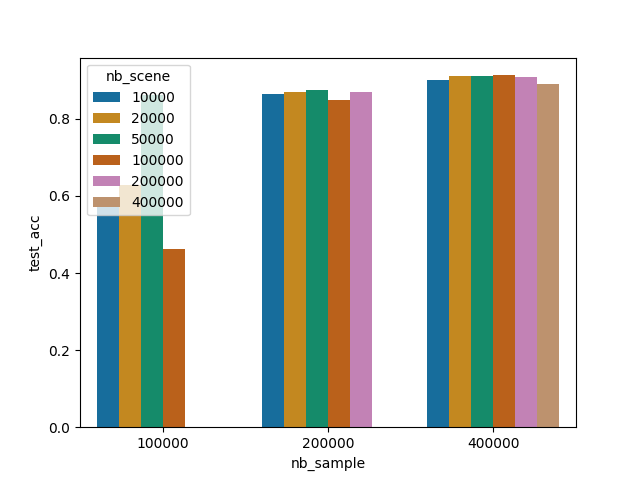

KeyError: 11

In [6]:
fig_name = "dataset_size_all_samples_giampi2.pdf"
df_filter = (experiments['note'] == 'dataset_size')
columns = ['nb_sample', 'nb_scene', 'nb_q_per_scene', 'test_acc']
dataset_size = experiments[df_filter].sort_values('nb_q_per_scene')
#print(dataset_size)

fig, ax = plt.subplots()
sns.set_palette("colorblind")
g = sns.barplot(x='nb_sample', y='test_acc', hue='nb_scene', data=dataset_size)
# the following is an ugly hack that only works if the accuracy values are all different!!
for patch in ax.patches:
    if np.isnan(patch.get_height()):
        continue
    idx = np.argmin(np.abs(dataset_size.test_acc-patch.get_height()))
    #g.text(patch.get_x()+patch.get_width()/2, patch.get_height(), dataset_size.nb_q_per_scene[idx], color='black', ha='center')
    g.text(patch.get_x()+patch.get_width()/2, 0.96, dataset_size.nb_q_per_scene[idx], color='black', ha='center')
g.text(0.5, 1.01, '# questions per scene', color='black')
plt.xlabel('# examples')
plt.ylabel('Accuracy')
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, title='# scenes', loc='lower right')

#fig.savefig(f"stats/{fig_name}", bbox_inches='tight')

In [8]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.5
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

<IPython.core.display.Javascript object>


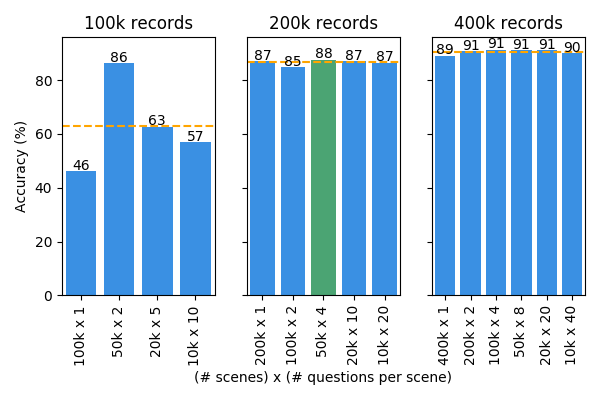

In [13]:
fig_name = "dataset_size_all_samples_giampi3.pdf"
df_filter = (experiments['note'] == 'dataset_size')
columns = ['nb_sample', 'nb_scene', 'nb_q_per_scene', 'test_acc']
dataset_size = experiments[df_filter].sort_values('nb_q_per_scene')
dataset_size['test_acc'] = dataset_size['test_acc'].apply(lambda x :x*100)
subset100k = dataset_size.nb_sample == 100000
subset200k = dataset_size.nb_sample == 200000
subset400k = dataset_size.nb_sample == 400000
#print(dataset_size)

fig, ax = plt.subplots(1,3, figsize=(6,4), sharey=True)
#sns.set_palette("colorblind")
g = sns.barplot(x='nb_q_per_scene', y='test_acc', data=dataset_size[subset100k], color='dodgerblue', ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_xticklabels(['100k x 1', '50k x 2', '20k x 5', '10k x 10'], rotation=90)
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('100k records')
mean = dataset_size[subset100k]['test_acc'].mean()
ax[0].axhline(y=mean, linestyle="--", color='orange')

#g = sns.barplot(x='nb_q_per_scene', y='test_acc', data=dataset_size[subset200k], color='dodgerblue', ax=ax[1])
g = sns.barplot(x='nb_q_per_scene', y='test_acc', data=dataset_size[subset200k], palette=['dodgerblue', 'dodgerblue', 'mediumseagreen', 'dodgerblue', 'dodgerblue'], ax=ax[1])

ax[1].set_xlabel('(# scenes) x (# questions per scene)')
ax[1].set_xticklabels(['200k x 1', '100k x 2', '50k x 4', '20k x 10', '10k x 20'], rotation=90)
ax[1].set_ylabel('')
ax[1].set_title('200k records')
mean = dataset_size[subset200k]['test_acc'].mean()
ax[1].axhline(y=mean, linestyle="--", color='orange')

g = sns.barplot(x='nb_q_per_scene', y='test_acc', data=dataset_size[subset400k], color='dodgerblue', ax=ax[2])
ax[2].set_xlabel('')
ax[2].set_xticklabels(['400k x 1', '200k x 2', '100k x 4', '50k x 8', '20k x 20', '10k x 40'], rotation=90)
ax[2].set_ylabel('')
ax[2].set_title('400k records')
mean = dataset_size[subset400k]['test_acc'].mean()
ax[2].axhline(y=mean, linestyle="--", color='orange')

for a in ax:
    show_values_on_bars(a)

plt.subplots_adjust(wspace=-0.5)
plt.tight_layout()
#h, l = ax.get_legend_handles_labels()
#ax.legend(h, l, title='# scenes', loc='lower right')

fig.savefig(f"stats/{fig_name}", bbox_inches='tight')

In [ ]:
print([f for f in dir(ax[2]) if '_' not in f])

In [ ]:
ax[2].lines[3].get_ydata()

In [ ]:
# Dataset size 400k - Data

columns = ['nb_trainable_param', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']

#print(grouped_by_sample_400k[columns].to_latex(index=False, formatters=latex_format_dict))
grouped_by_sample_400k[columns].style.format(latex_format_dict)

In [ ]:
# Dataset size 200k - Data

columns = ['nb_trainable_param', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']

#print(grouped_by_sample_200k[columns].to_latex(index=False, formatters=latex_format_dict))
grouped_by_sample_200k[columns].style.format(latex_format_dict)

In [ ]:
# Dataset size 100k - Data

columns = ['nb_trainable_param', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']

#print(grouped_by_sample_100k[columns].to_latex(index=False, formatters=latex_format_dict))
grouped_by_sample_100k[columns].style.format(latex_format_dict)